<a href="https://colab.research.google.com/github/anshupandey/26-Weeks-Of-Data-Science/blob/master/GAN_handwritten_digit_generation_using_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from tensorflow.keras import layers,models
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)

In [0]:
#load the data
(xtrain,ytrain),(xtest,ytest) = mnist.load_data()
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


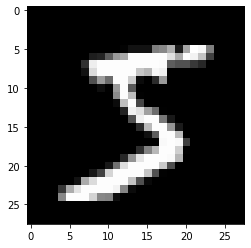

In [0]:
plt.imshow(xtrain[0],cmap='gray')
plt.show()

# Generator model


In [0]:
model1 = models.Sequential()
model1.add(layers.Dense(1000,input_shape=(100,),activation='relu'))
model1.add(layers.Dense(128*7*7,activation='relu'))
model1.add(layers.Reshape((7,7,128)))
model1.add(layers.UpSampling2D(size=(2,2)))
model1.add(layers.Conv2D(64,(5,5),padding="same",activation='relu'))
model1.add(layers.UpSampling2D(size=(2,2)))
model1.add(layers.Conv2D(1,(5,5),padding="same",activation='tanh'))


In [0]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1000)              101000    
_________________________________________________________________
dense_1 (Dense)              (None, 6272)              6278272   
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        204864    
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 1)         1

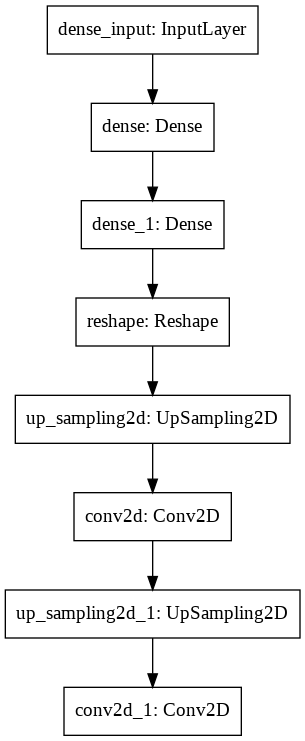

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model1)

# Discriminator

In [0]:
model2 = models.Sequential()
model2.add(layers.Conv2D(64,(5,5),activation='relu',input_shape=(28,28,1),padding='same'))
model2.add(layers.MaxPooling2D(pool_size=(2,2)))
model2.add(layers.Conv2D(128,(5,5),activation='relu',padding='same'))
model2.add(layers.MaxPooling2D(pool_size=(2,2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(100,activation='relu'))
model2.add(layers.Dense(1,activation='sigmoid'))


In [0]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 128)       204928    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               627300    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [0]:
model1.compile(loss='binary_crossentropy',optimizer='adam')
model2.compile(loss='binary_crossentropy',optimizer='adam')

In [0]:
model2.trainable=False
input_layer = layers.Input(shape=(100,))
layer1 = model1(input_layer) # layer1 = layers.Dense(10,activation='relu)(input_layer)
output_layer = model2(layer1)
final_model = models.Model(inputs=input_layer,outputs=output_layer)
final_model.compile(loss='binary_crossentropy',optimizer='adam')

In [0]:
final_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         6585737   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 833993    
Total params: 7,419,730
Trainable params: 6,585,737
Non-trainable params: 833,993
_________________________________________________________________


In [0]:
print(xtrain.shape)
print(xtest.shape)

(60000, 28, 28)
(10000, 28, 28)


In [0]:
xtrain = xtrain.reshape(60000,28,28,1)
xtest = xtest.reshape(10000,28,28,1)
xtrain = xtrain/255
xtest = xtest/255
print(xtrain.shape)
print(xtest.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [0]:
batch_size=1000

for i in range(10):
  steps_per_epoch = xtrain.shape[0]//batch_size
  for j in range(steps_per_epoch):
    noise_input = np.random.rand(batch_size,100)
    # getting prediction of images from generator by passing noise
    predictions = model1.predict(noise_input,batch_size=batch_size) 
    
    # getting a batch of 1000 images randomly picked form xtrain
    real_img_batch = xtrain[np.random.randint(0,60000,size=batch_size)]
    # concatenate the real images with the fake images

    x = np.concatenate([predictions,real_img_batch])
    y_dis = [0]*batch_size + [1]*batch_size

    y_dis = np.array(y_dis).reshape(-1,1)
    #train the discriminator
    model2.trainable=True
    model2.train_on_batch(x,y_dis)

    # train the generator
    noise_input = np.random.rand(batch_size,100)
    y_gen = [1]*batch_size
    y_gen = np.array(y_gen).reshape(-1,1)
    model2.trainable=False
    final_model.train_on_batch(noise_input,y_gen)
  print("epoch completed = ",i)






epoch completed =  0
epoch completed =  1
epoch completed =  2
epoch completed =  3
epoch completed =  4
epoch completed =  5
epoch completed =  6
epoch completed =  7
epoch completed =  8
epoch completed =  9


In [0]:
model1.save_weights("generator_weights")
model2.save_weights("discriminator_weights")


In [0]:
model1.compile(loss="binary_crossentropy",optimizer='adam')
model1.load_weights("generator_weights")

noise = np.random.rand(batch_size,100)
g_image = model1.predict(noise)
g_image.shape

(1000, 28, 28, 1)

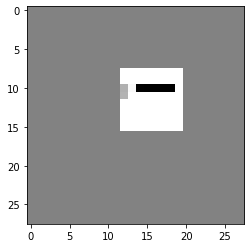

In [0]:
plt.imshow(g_image[500,:,:,:].reshape(28,28),cmap='gray')
plt.show()